In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 753.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import random
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
# Shell commands to download and prepare the IMDB review dataset
data_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
compressed_file = "aclImdb_v1.tar.gz"
unlabeled_dir = "aclImdb/train/unsup"

!curl {data_url} -O
!tar -xf {compressed_file}
!rm -r {unlabeled_dir}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  44.8M      0  0:00:01  0:00:01 --:--:-- 44.8M


In [4]:
import os

def summarize_imdb_dataset(root_dir="aclImdb", num_samples=5):
    for split in ["train", "test"]:
        print(f"\nOverview of '{split}' partition:")
        for sentiment in ["pos", "neg"]:
            print(f"  Label: {sentiment}")
            folder_path = os.path.join(root_dir, split, sentiment)
            chosen_files = os.listdir(folder_path)[:num_samples]
            for idx, file_name in enumerate(chosen_files):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, "r", encoding="utf-8") as f:
                    lines = f.readlines()
                print(f"\n  Example {idx + 1}: {file_name}")
                print(f"    Total lines: {len(lines)}")
                print(f"    Preview of first 5 lines (or fewer):")
                print("    " + "\n    ".join(lines[:5]).strip())

In [5]:
summarize_imdb_dataset()


Overview of 'train' partition:
  Label: pos

  Example 1: 9075_10.txt
    Total lines: 1
    Preview of first 5 lines (or fewer):
    I missed almost all of the first season, but when the other shows went to reruns, I started watching. I ended up buying the entire first season off iTunes. This is now one of my favorite comedy shows. Patrick Warburton is the key. His dry sense of humor has me rolling all the time. David Spade is funny, but sometimes a little Russell goes a long way. I enjoy the other cast members more (but not saying he doesn't add to the show).<br /><br />Do yourself a favor. If you haven't checked this one out, give it a try. If you can catch the episode where "Jeff" goes to the sperm bank, you will see how good this show is.<br /><br />I hope this series has a long run.

  Example 2: 2508_10.txt
    Total lines: 1
    Preview of first 5 lines (or fewer):
    This movie is amazing. The plot was just...wow.<br /><br />I was very surprised by Gackt's and Hyde's perform

In [6]:
import pathlib

# Prepare directory layout for train/validation split
batch_size = 32
root_dir = pathlib.Path("aclImdb")
val_dir = root_dir / "val"
train_dir = root_dir / "train"

for sentiment in ("neg", "pos"):
    os.makedirs(val_dir / sentiment, exist_ok=True)
    file_list = os.listdir(train_dir / sentiment)
    random.Random(1337).shuffle(file_list)
    num_val = int(0.2 * len(file_list))
    val_files = file_list[-num_val:]

    for filename in val_files:
        src = train_dir / sentiment / filename
        dst = val_dir / sentiment / filename
        if not os.path.exists(dst):
            shutil.move(src, dst)

In [9]:
# Construct dataset objects from the directory structure
training_dataset = keras.utils.text_dataset_from_directory(
    root_dir / "train", batch_size=batch_size
)

validation_dataset = keras.utils.text_dataset_from_directory(
    root_dir / "val", batch_size=batch_size
)

test_dataset = keras.utils.text_dataset_from_directory(
    root_dir / "test", batch_size=batch_size
)

# Generate a training dataset that contains only the raw text (no labels)
text_only_training = training_dataset.map(lambda features, targets: features)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [8]:
# Configure text vectorization hyperparameters
sequence_length = 150
vocab_size = 10000

text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Fit the vectorizer on the training text data
text_vectorizer.adapt(text_only_training)

In [10]:
# Apply the vectorizer to convert text datasets into integer sequences
tokenized_train = training_dataset.map(
    lambda features, labels: (text_vectorizer(features), labels),
    num_parallel_calls=4
).take(100)  # Limit training set to 100 samples

tokenized_val = validation_dataset.map(
    lambda features, labels: (text_vectorizer(features), labels),
    num_parallel_calls=4
).take(10000)  # Cap validation set at 10,000 samples

tokenized_test = test_dataset.map(
    lambda features, labels: (text_vectorizer(features), labels),
    num_parallel_calls=4
)

In [11]:
# Build a basic LSTM-based sentiment classifier with an embedding layer
input_tensor = keras.Input(shape=(None,), dtype="int64")
embedded_seq = layers.Embedding(input_dim=vocab_size, output_dim=128)(input_tensor)
lstm_features = layers.Bidirectional(layers.LSTM(32))(embedded_seq)
dropout_features = layers.Dropout(rate=0.3)(lstm_features)
output_tensor = layers.Dense(1, activation="sigmoid")(dropout_features)

sentiment_model = keras.Model(inputs=input_tensor, outputs=output_tensor)

sentiment_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

sentiment_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Configure a checkpoint callback to save the best version of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="embedding_model.keras",
        save_best_only=True
    )
]

In [13]:
# Train the model and capture the training history for later review
history_embedded = sentiment_model.fit(
    tokenized_train,
    validation_data=tokenized_val,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5040 - loss: 0.6924 - val_accuracy: 0.5536 - val_loss: 0.6829
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6392 - loss: 0.6390 - val_accuracy: 0.7308 - val_loss: 0.5667
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7897 - loss: 0.4855 - val_accuracy: 0.7584 - val_loss: 0.5093
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8512 - loss: 0.3750 - val_accuracy: 0.7748 - val_loss: 0.4949
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9033 - loss: 0.2704 - val_accuracy: 0.7958 - val_loss: 0.5049
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9065 - loss: 0.2609 - val_accuracy: 0.7938 - val_loss: 0.5179
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9390 - loss: 0.1749 - val_accuracy: 0.6814 - val_loss: 0.8103
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9531 - loss: 0.1519 - val_accu

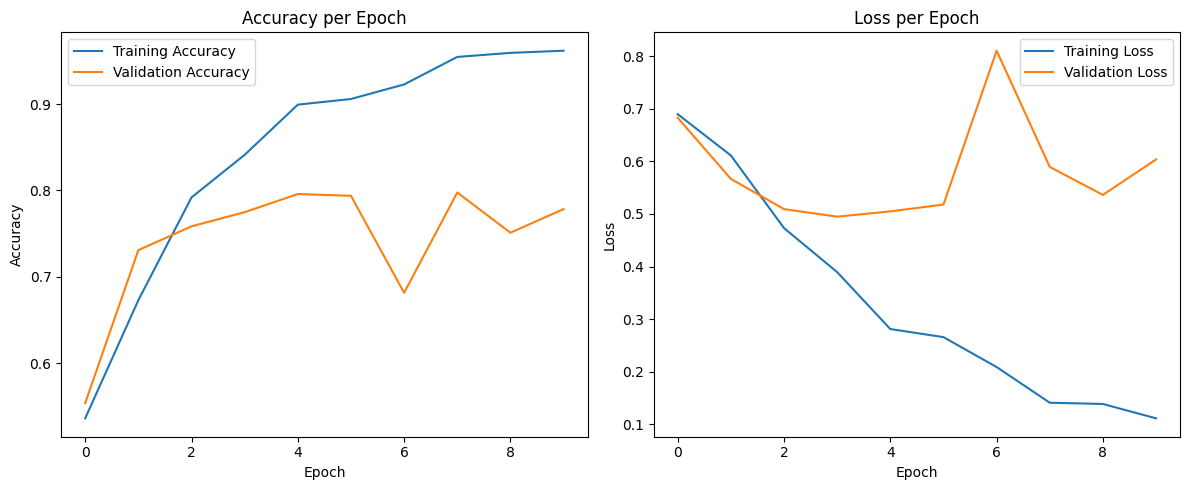

In [14]:
# Extract training history metrics from the model
training_stats = history_embedded.history

# Set up a figure with two side-by-side subplots
plt.figure(figsize=(12, 5))

# Plot training vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_stats["accuracy"], label="Training Accuracy")
plt.plot(training_stats["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(training_stats["loss"], label="Training Loss")
plt.plot(training_stats["val_loss"], label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Adjust spacing between plots and display them
plt.tight_layout()
plt.show()

In [15]:
# Download the GloVe 6B embeddings archive from Stanford NLP
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unpack the archive without verbose output
!unzip -q glove.6B.zip

--2025-11-10 18:25:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-10 18:25:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-10 18:25:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
# Build an embedding matrix initialized from pre-trained GloVe vectors
glove_dim = 100
glove_path = "glove.6B.100d.txt"

# Read GloVe vectors into a dictionary
glove_dict = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        token, vector_str = line.strip().split(maxsplit=1)
        glove_dict[token] = np.fromstring(vector_str, dtype="f", sep=" ")

# Align GloVe vectors with the vocabulary used by our TextVectorization layer
vocabulary = text_vectorizer.get_vocabulary()
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

embedding_matrix = np.zeros((vocab_size, glove_dim))
for word, idx in word_to_index.items():
    if idx < vocab_size:
        vec = glove_dict.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

In [17]:
# Construct an embedding layer that uses fixed (non-trainable) GloVe vectors
glove_embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=glove_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # Keep the imported GloVe weights frozen during training
    mask_zero=True
)

# Build the model architecture leveraging the pre-trained embedding layer
sequence_input = keras.Input(shape=(None,), dtype="int64")
sequence_embeddings = glove_embedding_layer(sequence_input)
lstm_features = layers.Bidirectional(layers.LSTM(32))(sequence_embeddings)
dropout_features = layers.Dropout(0.3)(lstm_features)
prediction_output = layers.Dense(1, activation="sigmoid")(dropout_features)

glove_model = keras.Model(inputs=sequence_input, outputs=prediction_output)

In [19]:
# Build a sentiment classifier leveraging the fixed GloVe-based embedding layer
input_tensor = keras.Input(shape=(None,), dtype="int64")
glove_embeddings = glove_embedding_layer(input_tensor)
lstm_features = layers.Bidirectional(layers.LSTM(32))(glove_embeddings)
dropout_features = layers.Dropout(0.3)(lstm_features)
output_scores = layers.Dense(1, activation="sigmoid")(dropout_features)

pretrained_model = keras.Model(inputs=input_tensor, outputs=output_scores)

# Configure the model for a binary sentiment prediction task
pretrained_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display a summary of the network architecture
pretrained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     34,048 │ embedding_1[1][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [20]:
# Set up a callback to store the best-performing GloVe-based model
glove_callbacks = [
    keras.callbacks.ModelCheckpoint("pretrained_model.keras", save_best_only=True)
]

# Fit the model on the tokenized datasets
history_glove = pretrained_model.fit(
    tokenized_train,
    validation_data=tokenized_val,
    epochs=10,
    callbacks=glove_callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5254 - loss: 0.6962 - val_accuracy: 0.6040 - val_loss: 0.6598
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6272 - loss: 0.6450 - val_accuracy: 0.6968 - val_loss: 0.5819
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6934 - loss: 0.5814 - val_accuracy: 0.6958 - val_loss: 0.6163
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7079 - loss: 0.5614 - val_accuracy: 0.7192 - val_loss: 0.5509
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7134 - loss: 0.5523 - val_accuracy: 0.6768 - val_loss: 0.5974
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7516 - loss: 0.5285 - val_accuracy: 0.7592 - val_loss: 0.5014
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7621 - loss: 0.4868 - val_accuracy: 0.7660 - val_loss: 0.4870
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7711 - loss: 0.4766 - val_acc

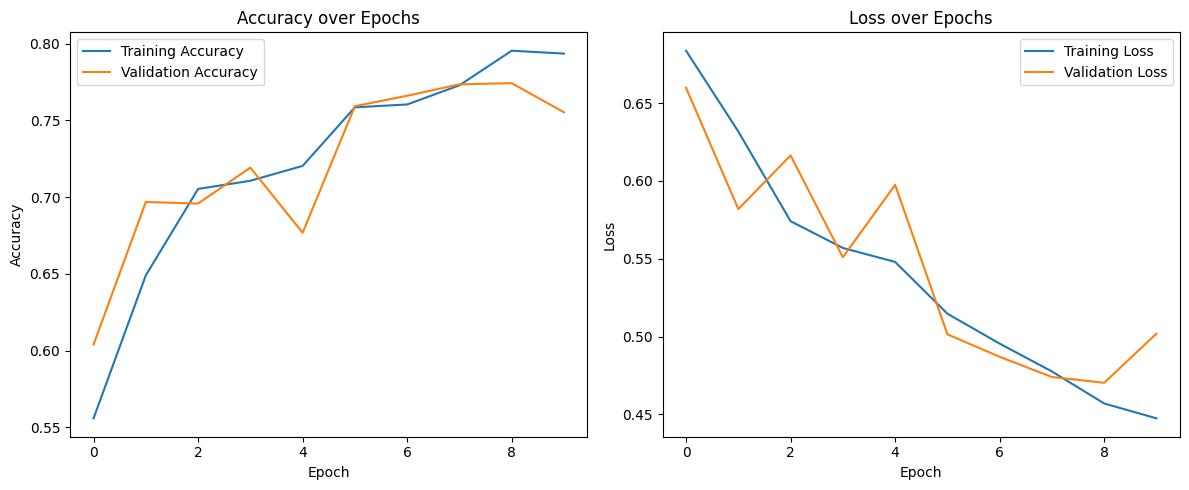

In [21]:
import matplotlib.pyplot as plt

# Pull the recorded metrics from the GloVe-trained model
metrics = history_glove.history

# Create a horizontal layout with two plots
plt.figure(figsize=(12, 5))

# Visualize accuracy for training and validation
plt.subplot(1, 2, 1)
plt.plot(metrics["accuracy"], label="Training Accuracy")
plt.plot(metrics["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Visualize loss for training and validation
plt.subplot(1, 2, 2)
plt.plot(metrics["loss"], label="Training Loss")
plt.plot(metrics["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Neatly arrange and display the plots
plt.tight_layout()
plt.show()


### Training with 100 samples ###

Training Custom Embedding Model on 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9830 - loss: 0.0626 - val_accuracy: 0.7576 - val_loss: 0.5850
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9894 - loss: 0.0471 - val_accuracy: 0.7688 - val_loss: 0.6605
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9916 - loss: 0.0385 - val_accuracy: 0.7462 - val_loss: 0.7233
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9860 - loss: 0.0438 - val_accuracy: 0.7506 - val_loss: 1.3050
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9881 - loss: 0.0440 - val_accuracy: 0.7766 - val_loss: 0.8688
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9800 - loss: 0.0641 - val_accuracy: 0.7794 - val_loss: 1.0051
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9876 - loss: 0.0366 - val_accuracy: 0.7760 - val_loss: 0.8310
Epoch 8/10
10

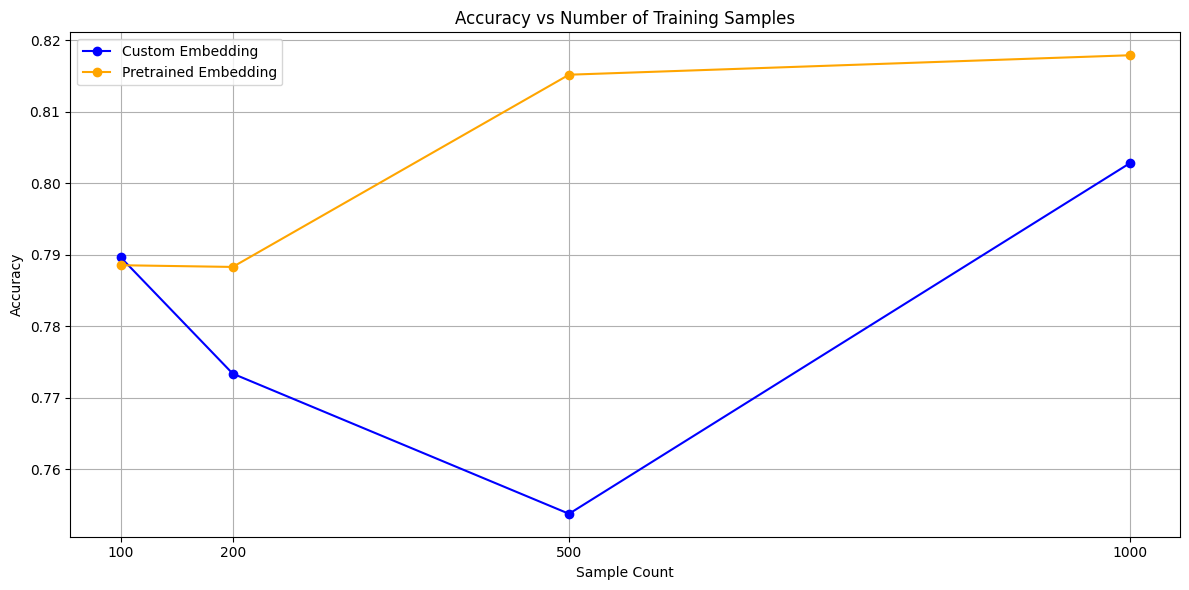

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Specify how many samples to use for successive training runs
sample_counts = [100, 200, 500, 1000]
custom_acc_list = []
glove_acc_list = []

# Initialize the figure for plotting accuracy trends
plt.figure(figsize=(12, 6))
plt.title("Accuracy vs Number of Training Samples")
plt.xlabel("Sample Count")
plt.ylabel("Accuracy")
plt.grid(True)

# Iterate over the configured sample sizes
for i, count in enumerate(sample_counts):
    print(f"\n### Training with {count} samples ###\n")

    # Limit the training dataset to the current sample count
    limited_train_data = training_dataset.map(
        lambda x, y: (text_vectorizer(x), y)
    ).take(count)

    # Train the model with custom-learned embeddings
    print(f"Training Custom Embedding Model on {count} samples:")
    sentiment_model.fit(
        limited_train_data,
        validation_data=tokenized_val,
        epochs=10,
        verbose=1
    )
    custom_accuracy = sentiment_model.evaluate(tokenized_test, verbose=1)[1]
    custom_acc_list.append(custom_accuracy)
    print(f"Custom Embedding Model Accuracy: {custom_accuracy:.4f}\n")

    # Train the model that uses fixed GloVe embeddings
    print(f"Training Pretrained Embedding Model on {count} samples:")
    pretrained_model.fit(
        limited_train_data,
        validation_data=tokenized_val,
        epochs=10,
        verbose=1
    )
    glove_accuracy = pretrained_model.evaluate(tokenized_test, verbose=1)[1]
    glove_acc_list.append(glove_accuracy)
    print(f"Pretrained Embedding Model Accuracy: {glove_accuracy:.4f}\n")

    # After the final iteration, draw both accuracy curves
    if i == len(sample_counts) - 1:
        plt.plot(sample_counts, custom_acc_list, marker="o", label="Custom Embedding", color="blue")
        plt.plot(sample_counts, glove_acc_list, marker="o", label="Pretrained Embedding", color="orange")

# Apply final labels and formatting to the chart
plt.title("Accuracy vs Number of Training Samples")
plt.xlabel("Sample Count")
plt.ylabel("Accuracy")
plt.xticks(sample_counts)
plt.grid(True)
plt.legend()

# Render the completed plot
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Record evaluation metrics for the model with trainable embeddings
custom_results = {
    "Data Count": sample_counts,
    "Accuracy (Custom Embedding)": custom_acc_list,
}

# Record evaluation metrics for the model using fixed GloVe embeddings
pretrained_results = {
    "Data Count": sample_counts,
    "Accuracy (Pretrained Embedding)": glove_acc_list,
}

# Build a DataFrame aggregating both result sets for comparison
results_table = pd.DataFrame({
    "Data Count": sample_counts,
    "Accuracy (Custom Embedding)": custom_acc_list,
    "Accuracy (Pretrained Embedding)": glove_acc_list
})

# Output the consolidated comparison table
print("Overall Accuracy Comparison:")
print(results_table)


Overall Accuracy Comparison:
   Data Count  Accuracy (Custom Embedding)  Accuracy (Pretrained Embedding)
0         100                      0.78964                          0.78852
1         200                      0.77336                          0.78828
2         500                      0.75376                          0.81516
3        1000                      0.80276                          0.81788


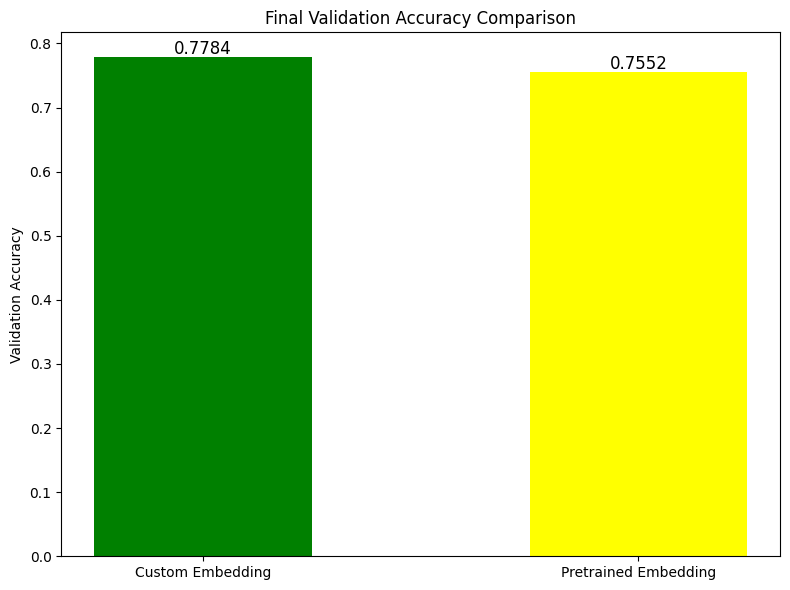

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Label each model and capture their final validation accuracies
model_names = ["Custom Embedding", "Pretrained Embedding"]
val_accuracies = [
    history_embedded.history["val_accuracy"][-1],  # Final validation accuracy of the custom model
    history_glove.history["val_accuracy"][-1]      # Final validation accuracy of the pretrained model
]

# Set up the bar plot to compare both models
plt.figure(figsize=(8, 6))
plt.bar(model_names, val_accuracies, color=["green", "yellow"], width=0.5)

# Add titles and axis descriptors
plt.ylabel("Validation Accuracy")
plt.title("Final Validation Accuracy Comparison")

# Annotate each bar with its numeric value
for idx, score in enumerate(val_accuracies):
    plt.text(idx, score + 0.005, f"{score:.4f}", ha="center", fontsize=12)

# Display the completed chart
plt.tight_layout()
plt.show()

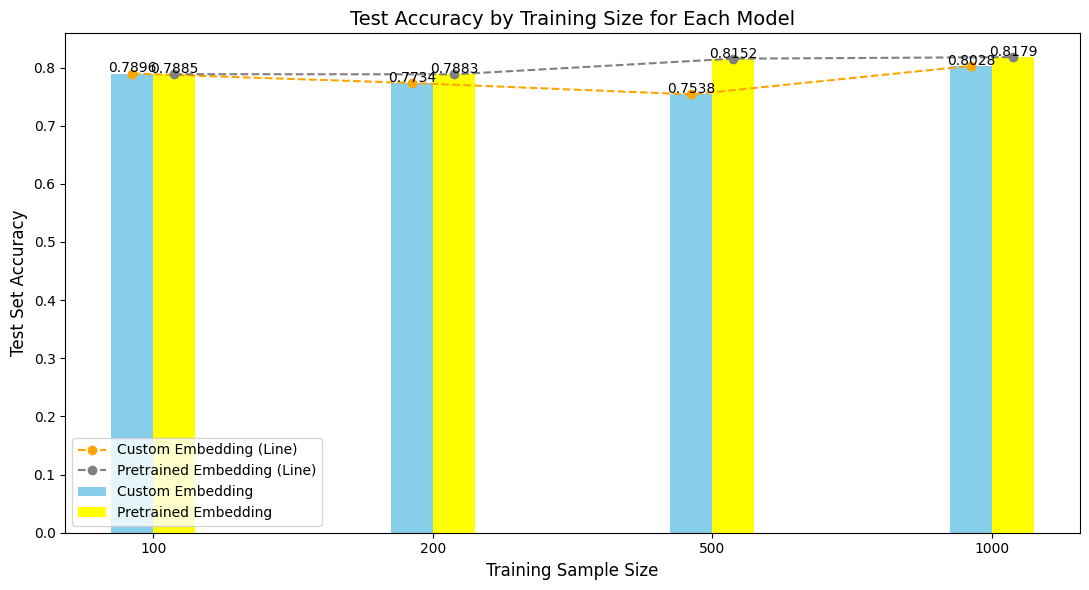

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define how many samples were used for training
train_sizes = [100, 200, 500, 1000]
custom_model_scores = [0.78964, 0.77336, 0.75376, 0.80276]      # Accuracy for the model with learned embeddings
glove_model_scores = [0.78852, 0.78828, 0.81516, 0.81788]       # Accuracy for the model with GloVe embeddings

# Configure bar placement positions
bar_width = 0.15
index_positions = np.arange(len(train_sizes))  # Central positions for each group of bars

# Create the plotting canvas
plt.figure(figsize=(11, 6))

# Draw grouped bars for both models
plt.bar(
    index_positions - bar_width / 2,
    custom_model_scores,
    width=bar_width,
    label="Custom Embedding",
    color="skyblue",
)
plt.bar(
    index_positions + bar_width / 2,
    glove_model_scores,
    width=bar_width,
    label="Pretrained Embedding",
    color="yellow",
)

# Add line plots on top of the bars to emphasize trends
plt.plot(
    index_positions - bar_width / 2,
    custom_model_scores,
    marker="o",
    color="orange",
    linestyle="--",
    label="Custom Embedding (Line)",
)
plt.plot(
    index_positions + bar_width / 2,
    glove_model_scores,
    marker="o",
    color="grey",
    linestyle="--",
    label="Pretrained Embedding (Line)",
)

# Configure chart labels, title, and legend
plt.xlabel("Training Sample Size", fontsize=12)
plt.ylabel("Test Set Accuracy", fontsize=12)
plt.title("Test Accuracy by Training Size for Each Model", fontsize=14)
plt.xticks(index_positions, train_sizes)
plt.legend()

# Place numeric accuracy labels above each bar
for i in range(len(train_sizes)):
    plt.text(
        index_positions[i] - bar_width / 2,
        custom_model_scores[i] + 0.002,
        f"{custom_model_scores[i]:.4f}",
        ha="center",
        fontsize=10,
    )
    plt.text(
        index_positions[i] + bar_width / 2,
        glove_model_scores[i] + 0.002,
        f"{glove_model_scores[i]:.4f}",
        ha="center",
        fontsize=10,
    )

# Render the finalized visualization
plt.tight_layout()
plt.show()
